# Chapter8. 차원축소

#### 차원의 저주
    수 많은 특성은 훈련을 느리게 할 뿐 아니라, 좋은 솔루션을 찾기 어렵게 만듬.
    
#### 차원 축소

* 정보 유실로 시스템 성능이 조금 나빠질 수 있으나, 어떤 경우에는 차원 축소로 잡음이나 불필요한 세부사항을 걸러내 성능을 높임. (일반적으로는 훈련 속도만 빨라짐.)
* 데이터 시각화에도 유용. 차원 수를 둘로 줄이면 고차원 훈련 세트를 하나의 그래프로 그릴 수 있으며, 군집 같은 시각적인 패턴도 감지 가능.
* 접근 방법 : 투영(projection), 매니폴드 학습(manifold learning)
* 기법 : PCA, 커널 PCA, LLE

## 8.1 차원의 저주


<img src="https://drive.google.com/uc?id=1kzDPl5aDtmYdIpao6ooCAmpPwrlCodFf" width="600">

3차원 세계에 살고 있는 우리는 고차원 공간을 직관적으로 상상하기 어려움.

#### 고차원의 특징
* 고차원 초입방체에 있는 대다수의 점은 경계와 매우 가까이 있음.
    * 1 x 1의 사각형안의 점을 무작위로 선택시 경계선(0.001) 이내에 위치할 확률은 0.4% ($1-(1-0.001*2)^2$)
    * 10,000차원의 단위 면적을 가진 초입방체의 경우 99.99999% (1-(1-0.001x2)^10000).
* 고차원의 두 점간의 차이는 매우 큼.
    * 단위 면적에서 임의의 두 점을 선택하면 두 점 사이의 거리는 평균 0.52
    * 3차원에서 평균 거리는 0.66
    * 1,000,000차원의 두 점을 평균 거리는 약 428.25 
    * 위의 내용은 차원이 복잡할 수록 샘플들도 멀리 떨어져 있으며 새로운 샘플이 훈련 샘플과 멀리 떨어져 있을 수 있음.(과대 적합될 수 있음)
    
차원의 저주를 해결하기 위해서는 훈련 샘플의 밀도가 충분히 높아질 때까지 훈련 세트를 추가하는 것.
하지만, 차원수가 커짐에 따라 기하급수적으로 늘어남.

## 8.2 차원 축소를 위한 접근 방법
### 8.2.1 투영
모든 훈련 샘플이 고차원 공간 안의 저차원 **부분 공간**에 놓여 있음.

<img src="https://drive.google.com/uc?id=14mX9cIRBRg_j4vGEw2VcSOQ2D72FsXVe" width="600">

위의 훈련 샘플이 거의 평면 형태로 놓여 있음. 이것이 고차원(3d) 공간에 있는 저차원(2d) 부분 공간.

모든 훈련 샘플을 이 부분 공간에 수직으로 투영하면 2d 데이터 셋을 얻을 수 있음.

<img src="https://drive.google.com/uc?id=1oTPeyErBEujAqw0yZgT-RgD8awXrmtgz" width="600">

차원 축소에 있어서 투영이 언제나 최선은 아님. **스위스 롤** 데이터 셋 처럼 부분 공간이 뒤틀리거나 휘어 있기도 함.

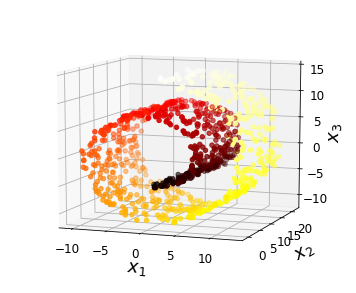

In [47]:
from sklearn.datasets import make_swiss_roll
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)
axes = [-11.5, 14, -2, 23, -12, 15]

fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=t, cmap=plt.cm.hot)
ax.view_init(10, -70)
ax.set_xlabel("$x_1$", fontsize=18, labelpad=7)
ax.set_ylabel("$x_2$", fontsize=18, labelpad=7)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

plt.show()

단순히 x3를 버리고 x1,x2로 투영하게 되면 아래 왼쪽 처럼 됨. 우리는 오른쪽 처럼 얻기를 원함.

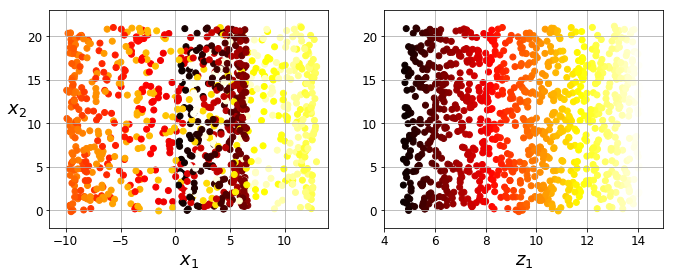

In [49]:
plt.figure(figsize=(11, 4))

plt.subplot(121)
plt.scatter(X[:, 0], X[:, 1], c=t, cmap=plt.cm.hot)
plt.axis(axes[:4])
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$x_2$", fontsize=18, rotation=0, labelpad=10)
plt.grid(True)

plt.subplot(122)
plt.scatter(t, X[:, 1], c=t, cmap=plt.cm.hot)
plt.axis([4, 15, axes[2], axes[3]])
plt.xlabel("$z_1$", fontsize=18)
plt.grid(True)

plt.show()

### 8.2.2 매니폴드 학습
d차원 매니폴드는 d차원 초평면으로 보일 수 있는 n차원 공간의 일부(d < n). 스위스 롤은 d=2, n=3임.
#### 매니폴드 학습
* 많은 차원 축소 알고리즘이 훈련 샘플이 놓여 있는 매니폴드를 모델링하는 식으로 동작.
* 실제 고차원 데이터셋이 더 낮은 저차원 매니폴드에 가갑게 놓여 있다는 매니폴드 가정, 가설에 근거.

MNIST 데이터 셋에서도 숫자 이미지는 선으로 연결되어 있고, 경계는 흰색, 어느 정도 중앙에 위치하며, 무작위로 생성된 이미지 중 아주 적은 일부만 숫자 이미지가 됨. 즉, 숫자 이미지의 자유도는 랜덤한 이미지보다 훨씬 낮으며, 이런 제약은 저차원의 매니폴드로 압축할 수 있도록 함.

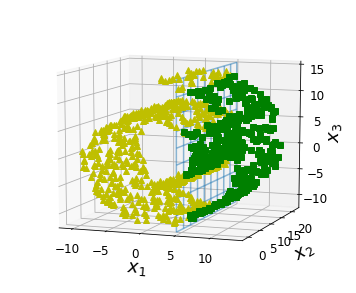

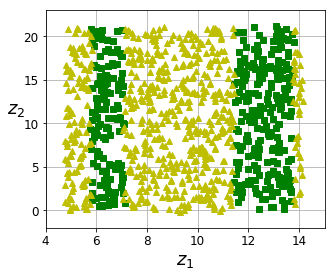

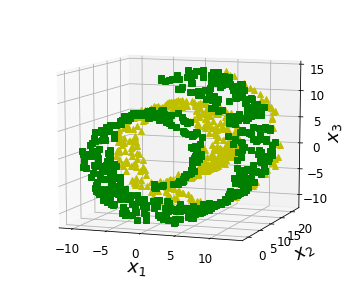

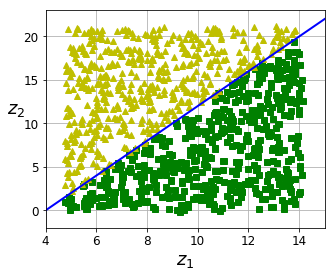

In [50]:
from matplotlib import gridspec

axes = [-11.5, 14, -2, 23, -12, 15]

x2s = np.linspace(axes[2], axes[3], 10)
x3s = np.linspace(axes[4], axes[5], 10)
x2, x3 = np.meshgrid(x2s, x3s)

fig = plt.figure(figsize=(6, 5))
ax = plt.subplot(111, projection='3d')

positive_class = X[:, 0] > 5
X_pos = X[positive_class]
X_neg = X[~positive_class]
ax.view_init(10, -70)
ax.plot(X_neg[:, 0], X_neg[:, 1], X_neg[:, 2], "y^")
ax.plot_wireframe(5, x2, x3, alpha=0.5)
ax.plot(X_pos[:, 0], X_pos[:, 1], X_pos[:, 2], "gs")
ax.set_xlabel("$x_1$", fontsize=18, labelpad=7)
ax.set_ylabel("$x_2$", fontsize=18, labelpad=7)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

plt.show()

fig = plt.figure(figsize=(5, 4))
ax = plt.subplot(111)

plt.plot(t[positive_class], X[positive_class, 1], "gs")
plt.plot(t[~positive_class], X[~positive_class, 1], "y^")
plt.axis([4, 15, axes[2], axes[3]])
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0, labelpad=7)
plt.grid(True)

plt.show()

fig = plt.figure(figsize=(6, 5))
ax = plt.subplot(111, projection='3d')

positive_class = 2 * (t[:] - 4) > X[:, 1]
X_pos = X[positive_class]
X_neg = X[~positive_class]
ax.view_init(10, -70)
ax.plot(X_neg[:, 0], X_neg[:, 1], X_neg[:, 2], "y^")
ax.plot(X_pos[:, 0], X_pos[:, 1], X_pos[:, 2], "gs")
ax.set_xlabel("$x_1$", fontsize=18, labelpad=7)
ax.set_ylabel("$x_2$", fontsize=18, labelpad=7)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

plt.show()

fig = plt.figure(figsize=(5, 4))
ax = plt.subplot(111)

plt.plot(t[positive_class], X[positive_class, 1], "gs")
plt.plot(t[~positive_class], X[~positive_class, 1], "y^")
plt.plot([4, 15], [0, 22], "b-", linewidth=2)
plt.axis([4, 15, axes[2], axes[3]])
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0, labelpad=7)
plt.grid(True)

plt.show()

분류와 회귀 등의 바로 처리해야 할 작업에서 저차원의 매니폴드 공간에 표현되면 더 간단해질 거라는 가정이 있음.<br>
위의 아래 스위스 롤은 매니폴드 공간에서는 결정 경계가 단순한 직선으로 나왔지만, 첫번째의 경우 x1=5인 3d 공간에서의 결정경계가 더 단순 함.

훈련 속도는 빨라지지만 항상 더 낫거나 간단한 솔루션이 되는건 아님.

## 8.3 PCA
#### 주성분 분석 : 가장 인기 있는 차원 축소 알고리즘. 데이터의 가까운 초평면을 정의한 후 투영.
### 8.3.1 분산 보존
올바른 초평면 선택이 중요함.

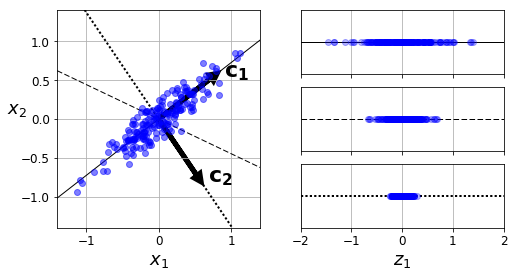

In [45]:
angle = np.pi / 5
stretch = 5
m = 200

np.random.seed(3)
X = np.random.randn(m, 2) / 10
X = X.dot(np.array([[stretch, 0],[0, 1]])) # stretch
X = X.dot([[np.cos(angle), np.sin(angle)], [-np.sin(angle), np.cos(angle)]]) # rotate

u1 = np.array([np.cos(angle), np.sin(angle)])
u2 = np.array([np.cos(angle - 2 * np.pi/6), np.sin(angle - 2 * np.pi/6)])
u3 = np.array([np.cos(angle - np.pi/2), np.sin(angle - np.pi/2)])

X_proj1 = X.dot(u1.reshape(-1, 1))
X_proj2 = X.dot(u2.reshape(-1, 1))
X_proj3 = X.dot(u3.reshape(-1, 1))

plt.figure(figsize=(8,4))
plt.subplot2grid((3,2), (0, 0), rowspan=3)
plt.plot([-1.4, 1.4], [-1.4*u1[1]/u1[0], 1.4*u1[1]/u1[0]], "k-", linewidth=1)
plt.plot([-1.4, 1.4], [-1.4*u2[1]/u2[0], 1.4*u2[1]/u2[0]], "k--", linewidth=1)
plt.plot([-1.4, 1.4], [-1.4*u3[1]/u3[0], 1.4*u3[1]/u3[0]], "k:", linewidth=2)
plt.plot(X[:, 0], X[:, 1], "bo", alpha=0.5)
plt.axis([-1.4, 1.4, -1.4, 1.4])
plt.arrow(0, 0, u1[0], u1[1], head_width=0.1, linewidth=5, length_includes_head=True, head_length=0.1, fc='k', ec='k')
plt.arrow(0, 0, u3[0], u3[1], head_width=0.1, linewidth=5, length_includes_head=True, head_length=0.1, fc='k', ec='k')
plt.text(u1[0] + 0.1, u1[1] - 0.05, r"$\mathbf{c_1}$", fontsize=22)
plt.text(u3[0] + 0.1, u3[1], r"$\mathbf{c_2}$", fontsize=22)
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$x_2$", fontsize=18, rotation=0)
plt.grid(True)

plt.subplot2grid((3,2), (0, 1))
plt.plot([-2, 2], [0, 0], "k-", linewidth=1)
plt.plot(X_proj1[:, 0], np.zeros(m), "bo", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.gca().get_xaxis().set_ticklabels([])
plt.axis([-2, 2, -1, 1])
plt.grid(True)

plt.subplot2grid((3,2), (1, 1))
plt.plot([-2, 2], [0, 0], "k--", linewidth=1)
plt.plot(X_proj2[:, 0], np.zeros(m), "bo", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.gca().get_xaxis().set_ticklabels([])
plt.axis([-2, 2, -1, 1])
plt.grid(True)

plt.subplot2grid((3,2), (2, 1))
plt.plot([-2, 2], [0, 0], "k:", linewidth=2)
plt.plot(X_proj3[:, 0], np.zeros(m), "bo", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.axis([-2, 2, -1, 1])
plt.xlabel("$z_1$", fontsize=18)
plt.grid(True)

plt.show()

c1은 분산을 최대로 보존하는 반면, c2는 분산을 매우 적게 유지함. 가운데의 파선은 분산을 중간 정도 유지함.<br>
분산이 최대로 보존되는 축을 선택하는 것이 정보가 가장 적게 손실되므로 합리적으로 보임.

원본 데이터셋과 투영된 것 사이의 평균 제곱 거리를 최소화하는 축을 결정.

### 8.3.2 주성분
PCA는 훈련 셍트에서 분산이 최대인 축을 찾는 것.

고차원의 데이터 셋에서는 분산이 최대인 축을 찾고, 이 축에 직교하며 분산이 최대한 축을 찾고 이를 반복하며 이전의 두 축에 직교하는 다음 축을 찾음. i번 째 축을 적의하는 단위 벡터를 i번째 **주성분(PC)**라고 부름.

특잇값 분해(SVD)라는 표준 행렬 분해 기술을 이용해 훈련 세트 행렬 X를 세 개 행렬의 점곱인 $ U \cdot \sum \cdot V^T $로 분해 되며. 모든 주성분이 V에 담겨 있음.

In [3]:
import numpy as np
import os

# 일관된 출력을 위해 유사난수 초기화
np.random.seed(42)

# 맷플롯립 설정
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

In [4]:
np.random.seed(4)
m = 60
w1, w2 = 0.1, 0.3
noise = 0.1

angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
X = np.empty((m, 3))
X[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
X[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
X[:, 2] = X[:, 0] * w1 + X[:, 1] * w2 + noise * np.random.randn(m)

`svd()` 함수는 `U`, `s` 그리고 `Vt`를 반환. `Vt`는 행렬 $\mathbf{V}$의 전치인 $\mathbf{V}^T$

In [6]:
X_centered = X - X.mean(axis=0) # 평균을 0으로~
U, s, Vt = np.linalg.svd(X_centered)

In [20]:
Vt.T

array([[ 0.93636116, -0.34027485, -0.08626012],
       [ 0.29854881,  0.90119108, -0.31420255],
       [ 0.18465208,  0.2684542 ,  0.94542898]])

### 8.3.3 d차원으로 투영하기
주성분 추출이 끝나면 처음 d개의 주성분으로 정의한 초펴면에 투영하여 데이터셋의 차원을 d차원으로 축소 시킬 수 있음.
$$ X_{d-proj}=X\cdot W_d $$

In [27]:
W2 = Vt.T[:, :2]
X2D = X_centered.dot(W2)
X2D_using_svd = X2D

### 8.3.4 사이킷런 사용하기


In [28]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 2) # 줄이고자 하는 차원 수 입력
X2D = pca.fit_transform(X) # 평균을 0으로 맞춰줄 필요 없음. (자동)

In [29]:
X2D[:5]

array([[ 1.26203346,  0.42067648],
       [-0.08001485, -0.35272239],
       [ 1.17545763,  0.36085729],
       [ 0.89305601, -0.30862856],
       [ 0.73016287, -0.25404049]])

In [30]:
X2D_using_svd[:5]

array([[-1.26203346, -0.42067648],
       [ 0.08001485,  0.35272239],
       [-1.17545763, -0.36085729],
       [-0.89305601,  0.30862856],
       [-0.73016287,  0.25404049]])

In [31]:
np.allclose(X2D, -X2D_using_svd)

True

In [32]:
pca.components_.T

array([[-0.93636116,  0.34027485],
       [-0.29854881, -0.90119108],
       [-0.18465208, -0.2684542 ]])

### 8.3.5 설명된 분산의 비율
explained_variance_ratio_ 변수를 통해 각 주성분 축에 따라 데이터셋의 분산 비율을 확인 가능

In [34]:
pca.explained_variance_ratio_

array([ 0.84248607,  0.14631839])

#### 복원 해보기

In [38]:
X3D_inv = pca.inverse_transform(X2D)

In [39]:
np.allclose(X3D_inv, X)

False

In [40]:
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d

class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)

In [41]:
axes = [-1.8, 1.8, -1.3, 1.3, -1.0, 1.0]

x1s = np.linspace(axes[0], axes[1], 10)
x2s = np.linspace(axes[2], axes[3], 10)
x1, x2 = np.meshgrid(x1s, x2s)

C = pca.components_
R = C.T.dot(C)
z = (R[0, 2] * x1 + R[1, 2] * x2) / (1 - R[2, 2])

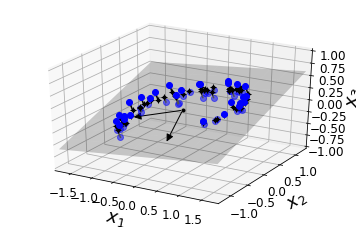

In [43]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(6, 3.8))
ax = fig.add_subplot(111, projection='3d')

X3D_above = X[X[:, 2] > X3D_inv[:, 2]]
X3D_below = X[X[:, 2] <= X3D_inv[:, 2]]

ax.plot(X3D_below[:, 0], X3D_below[:, 1], X3D_below[:, 2], "bo", alpha=0.5)

ax.plot_surface(x1, x2, z, alpha=0.2, color="k")
np.linalg.norm(C, axis=0)
ax.add_artist(Arrow3D([0, C[0, 0]],[0, C[0, 1]],[0, C[0, 2]], mutation_scale=15, lw=1, arrowstyle="-|>", color="k"))
ax.add_artist(Arrow3D([0, C[1, 0]],[0, C[1, 1]],[0, C[1, 2]], mutation_scale=15, lw=1, arrowstyle="-|>", color="k"))
ax.plot([0], [0], [0], "k.")

for i in range(m):
    if X[i, 2] > X3D_inv[i, 2]:
        ax.plot([X[i][0], X3D_inv[i][0]], [X[i][1], X3D_inv[i][1]], [X[i][2], X3D_inv[i][2]], "k-")
    else:
        ax.plot([X[i][0], X3D_inv[i][0]], [X[i][1], X3D_inv[i][1]], [X[i][2], X3D_inv[i][2]], "k-", color="#505050")
    
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "k+")
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "k.")
ax.plot(X3D_above[:, 0], X3D_above[:, 1], X3D_above[:, 2], "bo")
ax.set_xlabel("$x_1$", fontsize=18, labelpad=7)
ax.set_ylabel("$x_2$", fontsize=18, labelpad=7)
ax.set_zlabel("$x_3$", fontsize=18, labelpad=4)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

plt.show()

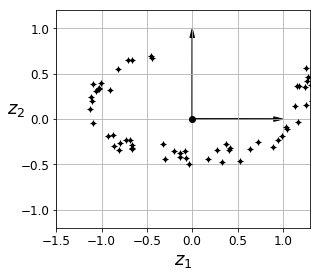

In [46]:
fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal')

ax.plot(X2D[:, 0], X2D[:, 1], "k+")
ax.plot(X2D[:, 0], X2D[:, 1], "k.")
ax.plot([0], [0], "ko")
ax.arrow(0, 0, 0, 1, head_width=0.05, length_includes_head=True, head_length=0.1, fc='k', ec='k')
ax.arrow(0, 0, 1, 0, head_width=0.05, length_includes_head=True, head_length=0.1, fc='k', ec='k')
ax.set_xlabel("$z_1$", fontsize=18)
ax.set_ylabel("$z_2$", fontsize=18, rotation=0)
ax.axis([-1.5, 1.3, -1.2, 1.2])
3ax.grid(True)

### 8.3.6 적절한 차원 수 선택하기
축소할 차원 수를 임의로 정하는 것 보다 충분한 분산이 될 때의 차원 수를 정하는 것이 좋다. 물론, 시각화를 위해서는 2,3개로 줄이는 것이 일반적.

In [54]:
from six.moves import urllib
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')

In [55]:
from sklearn.model_selection import train_test_split

X = mnist["data"]
y = mnist["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [56]:
pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1

In [61]:
X_train.shape

(52500, 784)

In [57]:
d

154

In [58]:
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_train)

In [59]:
pca.n_components_

154

In [60]:
np.sum(pca.explained_variance_ratio_)

0.9503623084769206

첫번째의 경우 n_components=d로 설정하여 PCA를 다시 실행해야하지만, 보존하려는 분산 비율을 n_components에 0.0~1.0 사이로 설정하는 편이 더 편함

<img src="https://drive.google.com/uc?id=1I0raeP7YDnQyITmb4IgB7QiK2leYbYKp" width="600">

### 8.3.7 압축을 위한 PCA

위를 통해 분산 95%를 유지하도록 PCA를 적용시 784개의 특성이 154개로 줄어든다. 즉 80%의 얍축이 가능하며, 분류 알고리즘의 속도를 크게 높일 수 있을 것임.

이때, 데이터를 다시 원래의 784차원으로 되돌릴 경우 원본 데이터셋은 얻을 수 없으나(5% 손실). 비슷한 모습일 것임.<br>
** 재구성 오차 **: 원본데이터와 재구성된 데이터 사이의 평균 제곱 거리

In [72]:
pca = PCA(n_components = 154)
X_reduced = pca.fit_transform(X_train)
X_recovered = pca.inverse_transform(X_reduced)

In [63]:
def plot_digits(instances, images_per_row=5, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")

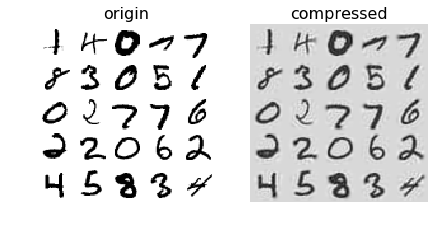

In [64]:
plt.figure(figsize=(7, 4))
plt.subplot(121)
plot_digits(X_train[::2100])
plt.title("origin", fontsize=16)
plt.subplot(122)
plot_digits(X_recovered[::2100])
plt.title("compressed", fontsize=16)


In [73]:
X_reduced_pca = X_reduced

### 8.3.8 점진적 PCA
PCA에서 SVD 알고리즘을 실행하기 위해 전체 훈련 세트를 메모리에 올려야함.

** 점진적 PCA(IPCA)** : 훈련 세트를 미니배치로 나눈 뒤 IPCA 알고리즘에 한번에 하나씩 주입. 온라인PCA 가능.

In [65]:
from sklearn.decomposition import IncrementalPCA

n_batches = 100
inc_pca = IncrementalPCA(n_components=154)
for X_batch in np.array_split(X_train, n_batches):
    print(".", end="") # not shown in the book
    inc_pca.partial_fit(X_batch)

X_reduced = inc_pca.transform(X_train)

....................................................................................................

In [67]:
X_recovered_inc_pca = inc_pca.inverse_transform(X_reduced)

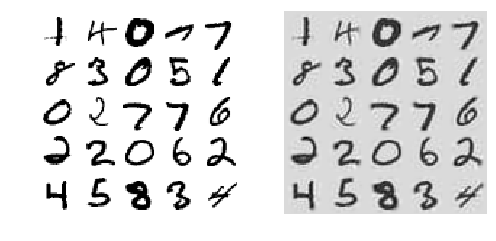

In [68]:
plt.figure(figsize=(7, 4))
plt.subplot(121)
plot_digits(X_train[::2100])
plt.subplot(122)
plot_digits(X_recovered_inc_pca[::2100])
plt.tight_layout()

In [69]:
X_reduced_inc_pca = X_reduced

In [74]:
np.allclose(pca.mean_, inc_pca.mean_)

True

In [75]:
np.allclose(X_reduced_pca, X_reduced_inc_pca)

False

PCA와 IPCA의 결과는 완전히 동일하지는 않음.
넘파이의 memmap 파이썬 클래스를 사용해 하드 디스크의 이진 파일에 저장된 매우 큰 배열을 메모리에 들어 있는 것 처럼 다룰 수도 있음.

In [76]:
filename = "my_mnist.data"
m, n = X_train.shape

X_mm = np.memmap(filename, dtype='float32', mode='write', shape=(m, n))
X_mm[:] = X_train

In [77]:
del X_mm

In [78]:
X_mm = np.memmap(filename, dtype="float32", mode="readonly", shape=(m, n))

batch_size = m // n_batches
inc_pca = IncrementalPCA(n_components=154, batch_size=batch_size)
inc_pca.fit(X_mm)

IncrementalPCA(batch_size=525, copy=True, n_components=154, whiten=False)

### 8.3.9 랜덤 PCA
**랜덤 PCA** : 확률적인 알고리즘으로, 첫 d개의 주성분에 대한 근사값을 빠르게 찾음.

In [79]:
# 주성분의 개수를 변경하며 PCA, IPCA, RPCA 비교.
import time

for n_components in (2, 10, 154):
    print("n_components =", n_components)
    regular_pca = PCA(n_components=n_components)
    inc_pca = IncrementalPCA(n_components=n_components, batch_size=500)
    rnd_pca = PCA(n_components=n_components, random_state=42, svd_solver="randomized")

    for pca in (regular_pca, inc_pca, rnd_pca):
        t1 = time.time()
        pca.fit(X_train)
        t2 = time.time()
        print("    {}: {:.1f} seconds".format(pca.__class__.__name__, t2 - t1))

n_components = 2
    PCA: 2.4 seconds
    IncrementalPCA: 25.7 seconds
    PCA: 1.8 seconds
n_components = 10
    PCA: 13.5 seconds
    IncrementalPCA: 173.4 seconds
    PCA: 2.2 seconds
n_components = 154
    PCA: 16.7 seconds
    IncrementalPCA: 390.7 seconds
    PCA: 6.0 seconds


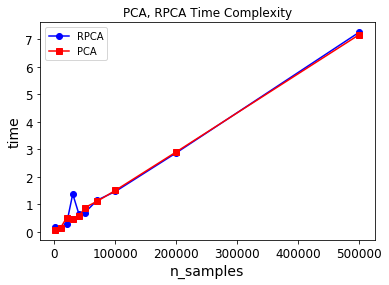

In [86]:
# 샘플 수를 변경하여 PCA, RPCA 비교
times_rpca = []
times_pca = []
sizes = [1000, 10000, 20000, 30000, 40000, 50000, 70000, 100000, 200000, 500000]
for n_samples in sizes:
    n_samples *= 10
    X = np.random.randn(n_samples, 5)
    pca = PCA(n_components = 2, svd_solver="randomized", random_state=42)
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_rpca.append(t2 - t1)
    pca = PCA(n_components = 2)
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_pca.append(t2 - t1)

plt.plot(sizes, times_rpca, "b-o", label="RPCA")
plt.plot(sizes, times_pca, "r-s", label="PCA")
plt.xlabel("n_samples")
plt.ylabel("time")
plt.legend(loc="upper left")
plt.title("PCA, RPCA Time Complexity")

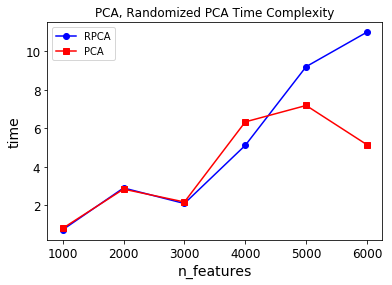

In [87]:
# 특성 수를 다르게 하여 PCA, RPCA 비교
times_rpca = []
times_pca = []
sizes = [1000, 2000, 3000, 4000, 5000, 6000]
for n_features in sizes:
    n_features *= 10
    X = np.random.randn(2000, n_features)
    pca = PCA(n_components = 2, random_state=42, svd_solver="randomized")
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_rpca.append(t2 - t1)
    pca = PCA(n_components = 2)
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_pca.append(t2 - t1)

plt.plot(sizes, times_rpca, "b-o", label="RPCA")
plt.plot(sizes, times_pca, "r-s", label="PCA")
plt.xlabel("n_features")
plt.ylabel("time")
plt.legend(loc="upper left")
plt.title("PCA, Randomized PCA Time Complexity")

## 8.4 커널 PCA
**kPCA** : PCA에 적용해 복잡한 비선형 투영으로의 차원 축소를 하는 것. 이 기법은 투영된 후에 샘플의 군집을 유지하거나 꼬인 매니폴드에 가까운 데이터셋을 펼칠 때도 유용.

In [88]:
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

In [89]:
from sklearn.decomposition import KernelPCA

rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.04)
X_reduced = rbf_pca.fit_transform(X)

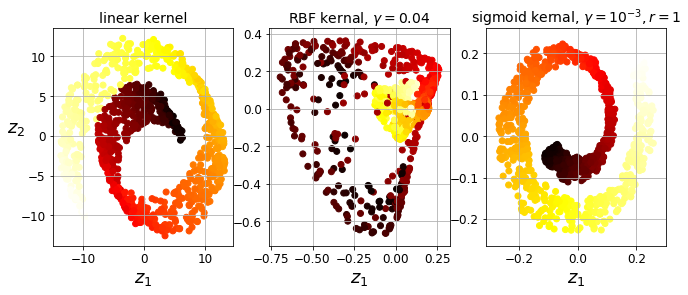

In [91]:
from sklearn.decomposition import KernelPCA

lin_pca = KernelPCA(n_components = 2, kernel="linear", fit_inverse_transform=True)
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.0433, fit_inverse_transform=True)
sig_pca = KernelPCA(n_components = 2, kernel="sigmoid", gamma=0.001, coef0=1, fit_inverse_transform=True)

y = t > 6.9

plt.figure(figsize=(11, 4))
for subplot, pca, title in ((131, lin_pca, "linear kernel"), (132, rbf_pca, "RBF kernal, $\gamma=0.04$"), (133, sig_pca, "sigmoid kernal, $\gamma=10^{-3}, r=1$")):
    X_reduced = pca.fit_transform(X)
    if subplot == 132:
        X_reduced_rbf = X_reduced
    
    plt.subplot(subplot)
    #plt.plot(X_reduced[y, 0], X_reduced[y, 1], "gs")
    #plt.plot(X_reduced[~y, 0], X_reduced[~y, 1], "y^")
    plt.title(title, fontsize=14)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)

plt.show()

### 8.4.1 커널 선택과 하이퍼파라미터 튜닝
kPCA는 비지도 학습이기 때문에 그리드 탐색을 사용하여 가장 좋은 커널과 하이퍼파라미터를 선택할 수 있음.

아래는 kPCA를 사용해 차원을 2차원으로 축소하고 분류를 위해 로지스틱 회귀 적용하며 파이프라인 마지막 단계에서 GridSearchCV를 사용해 kPCA의 가장 좋은 커널과 gamma 파라미터를 찾음

In [92]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

clf = Pipeline([
        ("kpca", KernelPCA(n_components=2)),
        ("log_reg", LogisticRegression())
    ])

param_grid = [{
        "kpca__gamma": np.linspace(0.03, 0.05, 10),
        "kpca__kernel": ["rbf", "sigmoid"]
    }]

grid_search = GridSearchCV(clf, param_grid, cv=3)
grid_search.fit(X, y)

GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(steps=[('kpca', KernelPCA(alpha=1.0, coef0=1, copy_X=True, degree=3, eigen_solver='auto',
     fit_inverse_transform=False, gamma=None, kernel='linear',
     kernel_params=None, max_iter=None, n_components=2, n_jobs=1,
     random_state=None, remove_zero_eig=False, tol=0)), ('log_reg', LogisticRegre...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'kpca__gamma': array([ 0.03   ,  0.03222,  0.03444,  0.03667,  0.03889,  0.04111,
        0.04333,  0.04556,  0.04778,  0.05   ]), 'kpca__kernel': ['rbf', 'sigmoid']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [93]:
print(grid_search.best_params_)

{'kpca__gamma': 0.043333333333333335, 'kpca__kernel': 'rbf'}


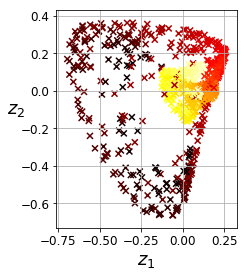

In [95]:
X_reduced = rbf_pca.fit_transform(X)

plt.figure(figsize=(11, 4))
plt.subplot(132)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot, marker="x")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)

또 다른 방법으로 가장 낮은 재구성 오차를 만드는 커널과 하이퍼파라미터를 선택하는 방식도 있음.

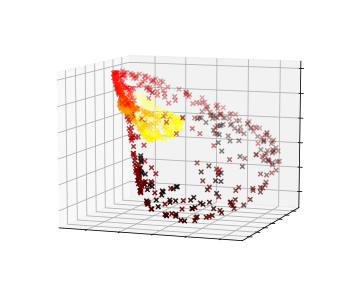

In [94]:
plt.figure(figsize=(6, 5))

X_inverse = rbf_pca.inverse_transform(X_reduced_rbf) // fit_inverse_transform=True 일 때만.

ax = plt.subplot(111, projection='3d')
ax.view_init(10, -70)
ax.scatter(X_inverse[:, 0], X_inverse[:, 1], X_inverse[:, 2], c=t, cmap=plt.cm.hot, marker="x")
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_zlabel("")
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])

plt.show()

In [96]:
from sklearn.metrics import mean_squared_error

mean_squared_error(X, X_inverse)

32.786308795766125

## 8.5 LLE
**지역 선형 임베딩** 
* Locally Linear Embedding은 강력한 비선형 차원 축소 기술
* 투영에 의존하지 않는 매니폴드 학습
* 각 훈련 샘플이 가장 가까운 이웃에 얼마나 선형적으로 연관되어 있는지 측정
* 국부적 관계가 가장 잘 보존되는 훈련세트의 저차원 표현을 찾음
* 잡음이 너무 많지 않는 꼬인 매니폴드를 펼치는데 유용


In [98]:
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=41)

In [99]:
from sklearn.manifold import LocallyLinearEmbedding

lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10, random_state=42)
X_reduced = lle.fit_transform(X)

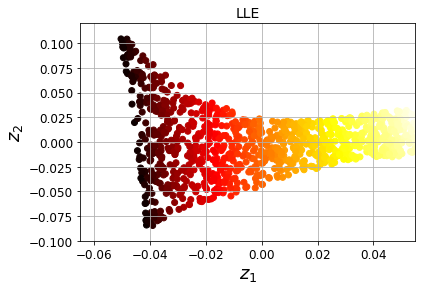

In [101]:
plt.title("LLE", fontsize=14)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18)
plt.axis([-0.065, 0.055, -0.1, 0.12])
plt.grid(True)

plt.show()

스위스 롤은 완전히 펼쳐졌고 지역적으로 샘플 간 거리가 잘 보존되어 있음. 하지만, 크게보면 샘플 간 거리가 잘 유지 되어있지 않음.<br>
우측은 압축되어 있고 좌측은 확장되어 있음. 그럼에도 매니폴드를 모델링하는 데 잘 동작함.

## 8.6 다른 차원 축소 기법
#### 다차원 스케일링 
* 샘플 간의 거리를 보존하며 차원을 축소함
#### lsomap
* 각 샘플을 가장 가까운 이웃과 연결하는 식으로 그래프를 만들고 샘플 간의 지오식 거리(두 노드 사이의 최단 경로를 이루는 노드 수)를 유지하면서 차원을 축소함
#### t-SNE
* 비슷한 샘플은 가까이, 비슷하지 않은 샘플은 멀리 떨어지도록 하면서 차원을 축소. 고차원 공간에 있는 샘플 군집을 시각화 할때 사용.
#### 선형 판별 분석 (LDA)
* 분류 알고리즘으로 클래스 사이를 가장 잘 구분하는 축을 학습함. 해당 축은 데이터가 투영되는 초평면을 정의하는데 사용할 수 있음. 투영을 통해 가능한 한 클래스를 멀리 떨어지게 유지시켜 SVM 불류기 같은 다른 분류 알고리즘을 적용하기 전에 차원 축소에 사용.

In [102]:
from sklearn.manifold import MDS

mds = MDS(n_components=2, random_state=42)
X_reduced_mds = mds.fit_transform(X)

from sklearn.manifold import Isomap

isomap = Isomap(n_components=2)
X_reduced_isomap = isomap.fit_transform(X)

from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
X_reduced_tsne = tsne.fit_transform(X)

In [103]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis(n_components=2)
X_mnist = mnist["data"]
y_mnist = mnist["target"]
lda.fit(X_mnist, y_mnist)
X_reduced_lda = lda.transform(X_mnist)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


In [108]:
X_reduced_lda.shape

(70000, 2)

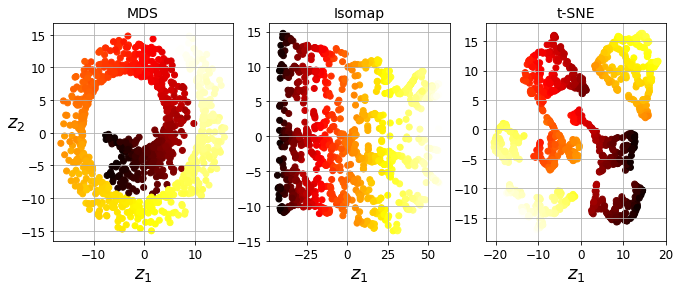

In [105]:
titles = ["MDS", "Isomap", "t-SNE"]

plt.figure(figsize=(11,4))

for subplot, title, X_reduced in zip((131, 132, 133), titles,
                                     (X_reduced_mds, X_reduced_isomap, X_reduced_tsne)):
    plt.subplot(subplot)
    plt.title(title, fontsize=14)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)

plt.show()